In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import os
import matplotlib

In [144]:
root_dir ="/Users/marcos/GitHubRepos/BioStatisticsDataDive/DataDive"
data_dir = root_dir+ "/data/processed/concatenated_data_csv/split_0/"

In [145]:
train = pd.read_csv(data_dir + "betas_train.csv")

In [146]:
train_betas = train.iloc[:, 1:-2]
train_betas=train_betas.div(train_betas.abs().sum(axis="columns"), axis=0)
train_clusters = train.iloc[:, -1].astype(int)
unique_train_clusters = train_clusters.unique()
true_train_centroids = {c: for c in unique_train_clusters}

n_classes = train_clusters.unique().shape[0]
# Use the new colormap interface (Matplotlib ≥ 3.7)
cmap = matplotlib.colormaps.get_cmap('tab10').resampled(n_classes)
# Assign a unique color to each unique label
color_dict = {label: cmap(i) for i, label in enumerate(train_clusters.unique())}
colors = np.array([color_dict[label] for label in train_clusters])
print(train_betas.shape)

(585, 834)


Text(0, 0.5, 'Regression Coefficient Against Trait')

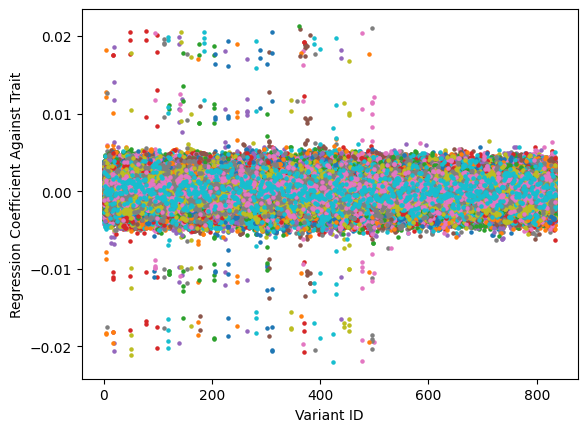

In [147]:
for k in range(train_betas.shape[0]):
    plt.scatter(np.arange(1, train_betas.shape[1]+1), train_betas.iloc[k, :],color=colors[k], s=5)
plt.xlabel("Variant ID")
plt.ylabel("Regression Coefficient Against Trait")

Text(0, 0.5, 'Mean Absolute Beta Vector')

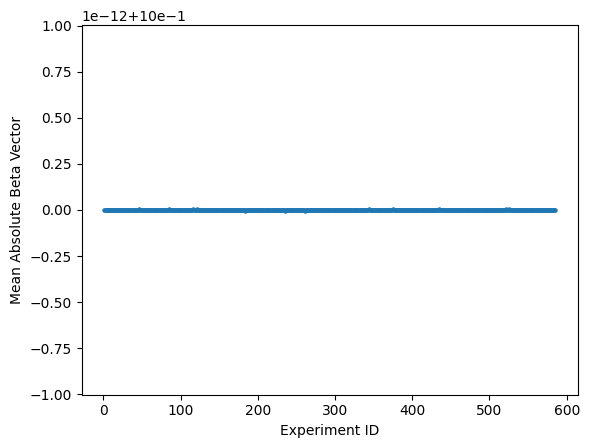

In [148]:
plt.scatter(np.arange(1, train_betas.shape[0]+1), train_betas.abs().sum(axis=1), s=5)
plt.xlabel("Experiment ID")
plt.ylabel("Mean Absolute Beta Vector")

In [149]:
val = pd.read_csv(data_dir + "betas_validate.csv")
val_betas = val.iloc[:, 1:-2]
val_betas=val_betas.div(val_betas.abs().sum(axis="columns"), axis=0)
val_clusters = val.iloc[:, -1].astype(int)
val_betas.shape

(195, 834)

In [150]:
from river import cluster
from river import stream
from river import preprocessing
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

# Create an online KMeans model
kmeans = KMeans(n_clusters=unique_train_clusters.shape[0], random_state=42, n_init='auto')
kmeans.fit(train_betas)

# Get cluster centroids
train_centroids = kmeans.cluster_centers_
train_cluster_indices = kmeans.labels_
num_samples_per_cluster = {c.item(): np.sum(train_cluster_indices == c).item() for c in np.unique(train_cluster_indices)}
train_ari = adjusted_rand_score(train_cluster_indices, train_clusters)

In [ ]:
# Try initialising with the true clusters
from river import cluster
from river import stream
from river import preprocessing
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

# Create an online KMeans model
kmeans = KMeans(n_clusters=unique_train_clusters.shape[0], random_state=42, n_init='auto')
kmeans.fit(train_betas)

# Get cluster centroids
train_centroids = kmeans.cluster_centers_
train_cluster_indices = kmeans.labels_
num_samples_per_cluster = {c.item(): np.sum(train_cluster_indices == c).item() for c in np.unique(train_cluster_indices)}
train_ari = adjusted_rand_score(train_cluster_indices, train_clusters)

In [152]:
# Stream in the data one point at a time
inc_clusters = []
fclusters = []
Nt = train_betas.shape[0]
for k, row in val_betas.iterrows():
    print(row.shape, train_centroids.shape)
    cidx = np.argmin(np.sum(np.power(train_centroids - row.to_numpy().reshape(1, -1),2), axis=-1)).item()
    inc_cluster = cidx
    inc_clusters.append(inc_cluster)
    print(f"Incremental update assigns to cluster: {inc_cluster}")

    # Update the centroid
    num_samples_per_cluster[cidx] +=1
    train_centroids[cidx, :] += (row.to_numpy()-train_centroids[cidx, :]) / num_samples_per_cluster[cidx]

    n_full_unique_clusters = np.unique(np.concatenate([train_clusters.to_numpy().flatten(),val_clusters[:k+1].to_numpy().flatten()])).shape[0]

    full_kmeans = KMeans(n_clusters=n_full_unique_clusters, random_state=42, n_init='auto')

    assert (val_betas.iloc[k,:] == row).all()
    full_kmeans.fit(pd.concat([train_betas, val_betas.iloc[:k+1, :]], axis=0))
    new_centroid = full_kmeans.cluster_centers_[full_kmeans.labels_[-1].item(), :]
    fcluster = np.argmin(np.sum(np.power(train_centroids - new_centroid.reshape(1, -1),2), axis=-1)).item()
    print(f"Full update assigns to cluster: {fcluster}")
    fclusters.append(fcluster)

print(np.array(inc_clusters).shape, np.array(fclusters).shape)
inc_ari = adjusted_rand_score(val_clusters, inc_clusters)
fari = adjusted_rand_score(val_clusters, fclusters)
print(f"Incremental vs Full ARI: {inc_ari}, {fari}")

(834,) (61, 834)
Incremental update assigns to cluster: 52
Full update assigns to cluster: 52
(834,) (61, 834)
Incremental update assigns to cluster: 43
Full update assigns to cluster: 17
(834,) (61, 834)
Incremental update assigns to cluster: 25
Full update assigns to cluster: 29
(834,) (61, 834)
Incremental update assigns to cluster: 24
Full update assigns to cluster: 2
(834,) (61, 834)
Incremental update assigns to cluster: 7
Full update assigns to cluster: 7
(834,) (61, 834)
Incremental update assigns to cluster: 16
Full update assigns to cluster: 39
(834,) (61, 834)
Incremental update assigns to cluster: 48
Full update assigns to cluster: 11
(834,) (61, 834)
Incremental update assigns to cluster: 0
Full update assigns to cluster: 36
(834,) (61, 834)
Incremental update assigns to cluster: 38
Full update assigns to cluster: 38
(834,) (61, 834)
Incremental update assigns to cluster: 2
Full update assigns to cluster: 17
(834,) (61, 834)
Incremental update assigns to cluster: 0
Full up